# Semantic mapping for KG visualization

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../semantic_mapping'))
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import circlify
import time as time

# Util library
import semantic_similarity

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics


# Computing similarity matrix
dataset_name = 'Got_Characters'
#semantic_similarity.build_similarity_matrix(dataset_name)

# Load similarity matrix

sim_matrix = np.loadtxt("similarity_matrices/{0}.txt".format(dataset_name))
sem_map = semantic_similarity.SemanticMap()
lst_names = sem_map.load_names(dataset_name)

display(sim_matrix)
display(lst_names)


array([[1.        , 0.80687351, 0.28834204, 0.59713033],
       [0.80687351, 1.        , 0.28834204, 0.50566167],
       [0.28834204, 0.28834204, 1.        , 0.33517101],
       [0.59713033, 0.50566167, 0.33517101, 1.        ]])

['Cersei_Lannister', 'Jaime_Lannister', 'Tywin_Lannister', 'Joffrey_Baratheon']

In [3]:
# Compute clusters using Affinity Propagation algorithm
print("Compute affinity propagation clustering...")
clustering = AffinityPropagation(random_state=10, max_iter=800).fit(sim_matrix)
display(clustering.labels_)
display(clustering.cluster_centers_indices_)

# Compute Intrinsic Measures to evaluate the cluster quality for Affinity Propagation
print("Silhouette index: %0.3f" % metrics.silhouette_score(sim_matrix, clustering.labels_, metric="sqeuclidean"))
print("Davies Bouldin score: %0.3f" % davies_bouldin_score(sim_matrix, clustering.labels_))
print("Calinski Harabasz score: %0.3f" % metrics.calinski_harabasz_score(sim_matrix, clustering.labels_))

Compute affinity propagation clustering...


array([0, 0, 1, 0])

array([0, 2])

Silhouette index: 0.529
Davies Bouldin score: 0.309
Calinski Harabasz score: 4.843


In [3]:
# Compute hierarchical-algorithm

print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=5, linkage="single").fit(sim_matrix)
elapsed_time = time.time() - st

print("Silhouette index: %0.3f" % metrics.silhouette_score(sim_matrix, ward.labels_, metric="sqeuclidean"))
print("Davies Bouldin score: %0.3f" % davies_bouldin_score(sim_matrix, ward.labels_))
print("Calinski Harabasz score: %0.3f" % metrics.calinski_harabasz_score(sim_matrix, ward.labels_))

Compute unstructured hierarchical clustering...
Silhouette index: 0.217
Davies Bouldin score: 1.096
Calinski Harabasz score: 3.515


In [13]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(sim_matrix, quantile=0.77, n_samples=289)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
ms.fit(sim_matrix)

print("Silhouette index: %0.3f" % metrics.silhouette_score(sim_matrix, ms.labels_, metric="sqeuclidean"))
print("Davies Bouldin score: %0.3f" % davies_bouldin_score(sim_matrix, ms.labels_))
print("Calinski Harabasz score: %0.3f" % metrics.calinski_harabasz_score(sim_matrix, ms.labels_))

Silhouette index: 0.571
Davies Bouldin score: 0.457
Calinski Harabasz score: 4.153


In [4]:
# Create semantic maps using the exemplars as centers
exemplars_label_dict = {}
for i in range(0, len(clustering.labels_)):
    if clustering.labels_[i] not in exemplars_label_dict.keys():
        exemplars_label_dict[clustering.labels_[i]] = []
    exemplars_label_dict[clustering.labels_[i]].append(i)

# Replace the key in the dict to use the exmplar index as key instead of cluster label
exemplars_dict = {}
for k, v in exemplars_label_dict.items():
    filtered = filter(lambda center: center in clustering.cluster_centers_indices_, v)
    exemplars_dict[list(filtered)[0]] = v
del exemplars_label_dict


# Create list of edges
lst_sources = []
lst_targets = []
for k, v in exemplars_dict.items():
    for idx in v:
        if idx != k or len(v) == 1:
            lst_sources.append(lst_names[k])
            lst_targets.append(lst_names[idx])

# Create DataFrame
df = pd.DataFrame(list(zip(lst_sources, lst_targets)), columns=['source', 'target'])
display(df)


,source,target
0,Cersei_Lannister,Jaime_Lannister
1,Cersei_Lannister,Joffrey_Baratheon
2,Tywin_Lannister,Tywin_Lannister


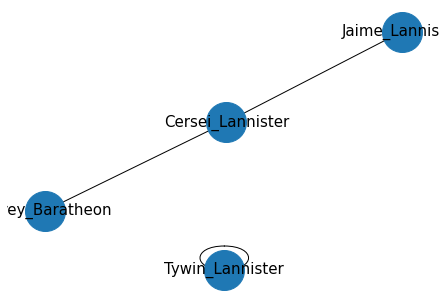

In [5]:
# Draw static network
G = nx.from_pandas_edgelist(df,
                           source='source',
                           target='target')
nx.draw_kamada_kawai(G,
                    with_labels=True,
                    node_size=1600,
                     edge_color='black',
                     linewidths=1,
                     font_size=15)

Picture saved successfully


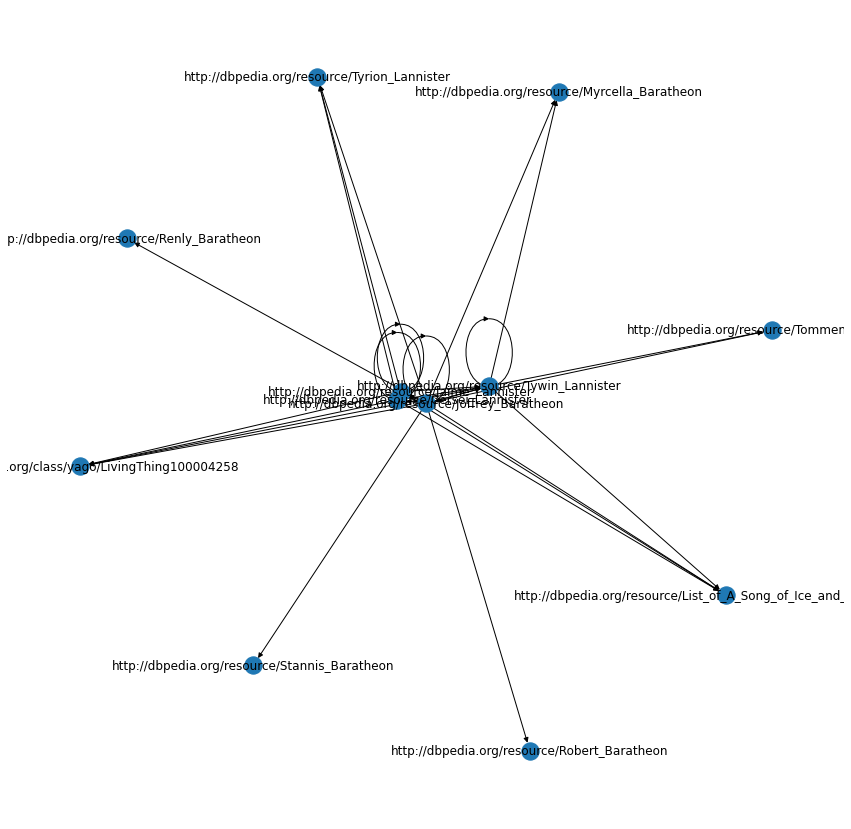

In [6]:
from pyvis.network import Network
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

plt.rcParams["figure.figsize"] = (15,15)

g = rdflib.Graph()
result = g.parse("datasets/{0}.nt".format(dataset_name))
GG = rdflib_to_networkx_multidigraph(result)

pos = nx.spiral_layout(GG)
edge_labels = nx.get_edge_attributes(GG, 'r')
nx.draw_networkx_edge_labels(GG, pos, edge_labels=edge_labels)
nx.draw(GG, with_labels=True)
plt.savefig('origin.png')

print("Picture saved successfully")
#if not in interactive mode for 
#plt.show()

net = Network(notebook=True)
net.from_nx(G)
net.show('demo.html')